In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import ccf

10 -0.10206629556464589


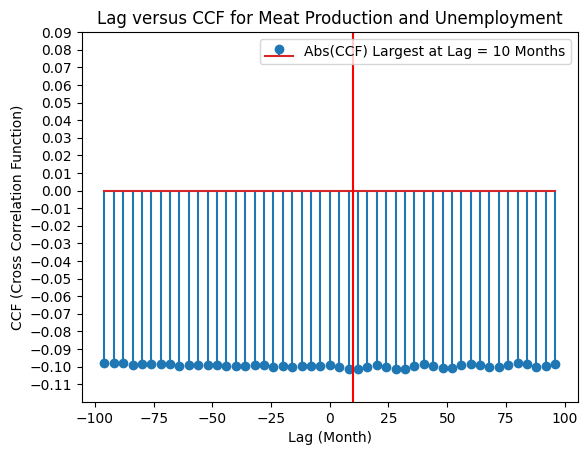

In [12]:
production_df = pd.read_csv('../cleaned-datasets/Cleaned_Meat_Stats_Meat_Production.csv')
economic_df = pd.read_csv('../cleaned-datasets/interpolated_economic_data.csv')
economic_df['Date'] = economic_df['date']

# Averaging data from top meatpacking and poultry processing states into one data point per year
condition_1_states = ["Nebraska", "Iowa", "Texas", "Kansas", "Illinois"]
condition_1 = economic_df["state"].isin(condition_1_states)
condition_2_states = ["Georgia", "Arkansas", "North Carolina", "Alabama", "Mississippi"]
condition_2 = economic_df['state'].isin(condition_2_states)
new_economic_df = economic_df[condition_1 | condition_2].copy()

# Merge datasets on 'Year'
data = pd.merge(production_df, new_economic_df, on='Date')
data.set_index('Date')

# Create an array of lag values
num = 96
lags = np.arange(-num, num + 1)

# Calculating cross-correlation for negative lags
neg_ccf = ccf(data['unemployment_rate'], data['Production'])
neg_ccf = neg_ccf[:num + 1][::-1]

# Combine with non-negative lags
pos_ccf = ccf(data['Production'], data['unemployment_rate'])
all_ccf = list(neg_ccf) + list(pos_ccf[1:num + 1])

# print(all_ccf)

min_index = 0
for i in range(0, len(all_ccf)):
    if all_ccf[i] < all_ccf[min_index]:
        min_index = i
print(min_index - num, all_ccf[min_index])

# Slice the arrays to make the graph less overwhelming
lags_sliced = lags[::4]
ccf_sliced = all_ccf[::4]

plt.stem(lags_sliced, ccf_sliced, label=f'Abs(CCF) Largest at Lag = {min_index - num} Months')
plt.xlabel('Lag (Month)')
plt.ylabel('CCF (Cross Correlation Function)')
plt.axvline(x=min_index - num, color="red")
plt.ylim(-0.12, 0)
plt.yticks(np.arange(-0.11, 0.1, 0.01)) # set y-axis ticks at intervals
plt.title('Lag versus CCF for Meat Production and Unemployment')
plt.legend()
plt.savefig('../visualizations/Lag Correlation Coefficients.png')
plt.show()